# Ensambles

A lo largo del notebook vamos a trabajar con el siguiente dataset:

https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

### Carga de datos

Volvemos a cargas las librerías, importar el dataset y limpiarlo.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.tree import DecisionTreeClassifier

import sklearn.metrics as metrics

from sklearn.model_selection import learning_curve

In [8]:
data = pd.read_csv("weatherAUS.csv")

In [9]:
data.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [10]:

# Columnas con muchos NaNs
columnas_descartables = ['Sunshine','Evaporation','Cloud3pm','Cloud9am','Location','Date']
data = data.drop(columns=columnas_descartables)
data = data.dropna()

# Columnas con variables categoricas
columnas_descartables = ['WindGustDir','WindDir9am','WindDir3pm','RainToday']
data = data.drop(columns=columnas_descartables)

# Variables correlacionadas
data = data.drop(columns=['Temp3pm', 'Pressure9am'])

# Mapeo
data['RainTomorrow'] = data['RainTomorrow'].map({'Yes':1,'No':0})

In [11]:
data.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure3pm,Temp9am,RainTomorrow
0,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.1,16.9,0
1,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1007.8,17.2,0
2,12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1008.7,21.0,0
3,9.2,28.0,0.0,24.0,11.0,9.0,45.0,16.0,1012.8,18.1,0
4,17.5,32.3,1.0,41.0,7.0,20.0,82.0,33.0,1006.0,17.8,0


## 1. Boosting

El objetivo de boosting es generar un modelo fuerte a partir de entrenar sucesivamente modelos débiles y combinar sus resultados. La idea es que cada modelo débil que agrego se enfoque en las instancias que fueron clasificadas erroneamente hasta el momento. Empecemos por decidir sobre qué features del dataset vamos a trabajar (si trabajan sobre 2, luego podrán visualizar):

In [12]:
# Elegimos sobre que coolumnas queremos trabajar
columnas_entrenamiento = ['MaxTemp', 'Humidity3pm']
X = data[columnas_entrenamiento]
y = data['RainTomorrow']

# Separamos los datos en train y test (held-out)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify = y)

Recordemos que este tipo de ensamble se enfoca en mejorar el sesgo de los modelos individuales a partir de los cuales está construido, por lo cual se suele usar modelos de alto sesgo y baja varianza.

1. Empiece por importar el clasificador AdaBoostClassifier y el modelo que usaremos como estimador debil, el DecisionTreeClassifier

In [13]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

2. Defina el modelo de manera que utilice 250 árboles de profundidad dos (2). Luego probaremos que sucede para mayores profundidades.

In [14]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),algorithm='SAMME', n_estimators=50)
# Entrenamos el modelo
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2))

3. Calcule el error sobre el training set y sobre el test set. En base a estos resultados, ¿les parece que este ensamble está inclinado hacia el sesgo o hacia la varianza?

In [19]:
y_train_pred = ada_clf.predict(X_train)
y_test_pred = ada_clf.predict(X_test)
print(metrics.accuracy_score(y_train, y_train_pred))
print(metrics.accuracy_score(y_test, y_test_pred))

0.8290257694789176
0.8302733337269024


4. Veamos ahora cómo es la distribución de los pesos de cada árbol. Para esto vamos a graficar el número del árbol vs el peso que el algoritmo le está dando para la clasificación final. Además, graficaremos también el accuracy de cada arbol sobre el training set.

Text(0.5, 0, 'Número de árbol')

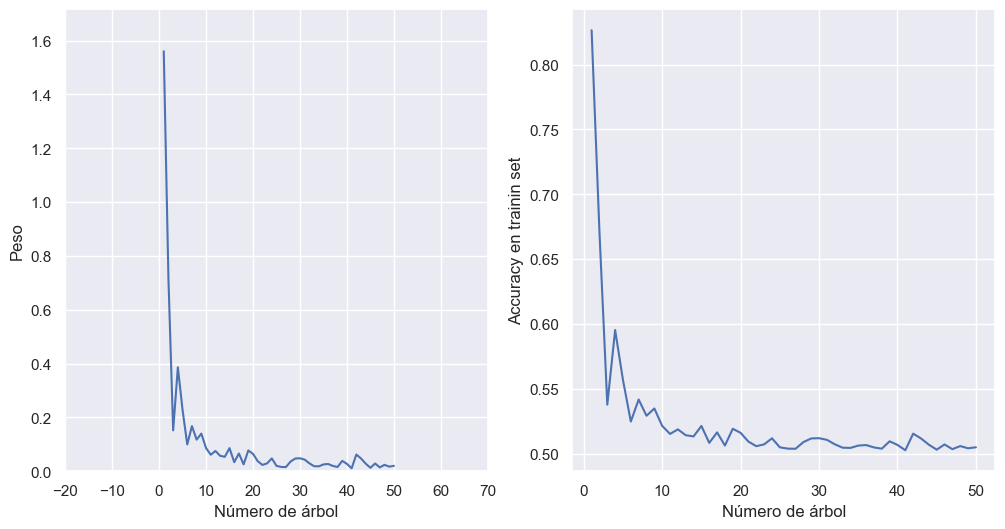

In [16]:
# Puede que el algoritmo termine antes de agregar todos los arboles
# Tomamos entonces la cantidad de arboles que realmente tiene el ensamble
numero_arboles = len(ada_clf)

# En la variable estimator_weights_ esta el peso de cada arbol
pesos = ada_clf.estimator_weights_[:numero_arboles]

# Calculamos el accuracy DE CADA ARBOL en el ensamble. En estimator_errors_ esta el error que comete cada uno.
errores_arboles = ada_clf.estimator_errors_[:numero_arboles]
accuracy_arboles = 1-errores_arboles # el acurracy es el complemento del error (todo lo que no erra)

# Graficamos
plt.figure(figsize = (12,6))
plt.subplot(121)
# En el eje 'x' ponemos el índice (número) de cada arbol, en el 'y' los pesos
plt.plot(range(1, numero_arboles + 1), pesos)
plt.ylabel('Peso')
plt.xlabel('Número de árbol')
plt.ylim((0, pesos.max() * 1.1))
plt.xlim((-20, numero_arboles + 20))
plt.subplot(122)
# En el eje 'x' ponemos el índice (número) de cada arbol, en el 'y' el accuracy de cada arbol
plt.plot(range(1, numero_arboles + 1), accuracy_arboles)
plt.ylabel('Accuracy en trainin set')
plt.xlabel('Número de árbol')

In [30]:
ada_clf.estimator_weights_

array([1.579274  , 0.72600838, 0.32734721, 0.20893262, 0.23384049,
       0.15187968, 0.15122172, 0.13071639, 0.03742247, 0.06783843,
       0.02749137, 0.02807137, 0.06660929, 0.06195599, 0.05544943,
       0.03856421, 0.02746036, 0.02511253, 0.02109085, 0.01479276,
       0.01483713, 0.02265511, 0.02459481, 0.01782224, 0.01304454,
       0.01474863, 0.01478631, 0.0280346 , 0.05481908, 0.02830135,
       0.01993801, 0.03299022, 0.03249376, 0.03586732, 0.03557015,
       0.02991655, 0.03791133, 0.01968545, 0.02866294, 0.02521324,
       0.00986325, 0.01343482, 0.01674499, 0.01377628, 0.02665399,
       0.02457381, 0.01290078, 0.01188395, 0.01147492, 0.01116541])

In [31]:
ada_clf.estimator_errors_

array([0.17089833, 0.32607127, 0.41888623, 0.44795603, 0.44180482,
       0.4621029 , 0.46226645, 0.46736736, 0.49064547, 0.48304689,
       0.49312759, 0.49298262, 0.48335383, 0.48451595, 0.48614119,
       0.49036014, 0.49313534, 0.4937222 , 0.49472748, 0.49630188,
       0.49629078, 0.49433646, 0.49385161, 0.49554456, 0.49673891,
       0.49631291, 0.49630349, 0.49299181, 0.48629866, 0.49292514,
       0.49501566, 0.49175319, 0.49187727, 0.49103413, 0.4911084 ,
       0.49252142, 0.4905233 , 0.4950788 , 0.49283476, 0.49369702,
       0.49753421, 0.49664135, 0.49581385, 0.49655599, 0.4933369 ,
       0.49385686, 0.49677485, 0.49702905, 0.4971313 , 0.49720868])

5. ¿Le parece relevante la contribución de todos los árboles?¿Cómo se relaciona el accuracy de cada árbol con el peso que le damos en la clasificación final?

6. Veamos cómo cambia el error en el training set y en el test set a medida que agregamos árboles. Para esto vamos a utilizar un metodo llamado `staged_predict`, que nos devuelve la predicción del ensamble en cada instancia en que fuimos agregandole un nuevo estimador.

c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Text(0.5, 0, 'Número de árboles')

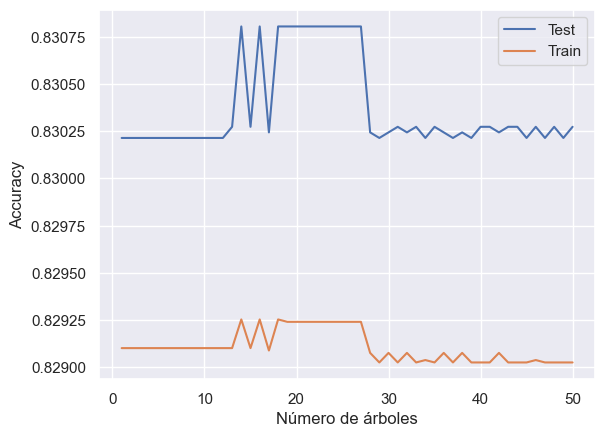

In [32]:
accuracy_test = []
accuracy_train = []
# Calculamos el accuracy sobre el test set
for prediccion_test in ada_clf.staged_predict(X_test):
    accuracy_test.append(metrics.accuracy_score(prediccion_test,y_test))

for prediccion_train in ada_clf.staged_predict(X_train):
    accuracy_train.append(metrics.accuracy_score(prediccion_train,y_train))

plt.plot(range(1, len(accuracy_test) + 1), accuracy_test, label = 'Test')
plt.plot(range(1, len(accuracy_test) + 1), accuracy_train, label = 'Train')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Número de árboles')

In [ ]:
ada_clf.estimators_

[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=309647853, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=203677265, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                        max_features=None, max_leaf_nodes=None,
                        min_impuri

In [ ]:
estimador0 = ada_clf.estimators_[0]
y_test_pred_0 = estimador0.predict(X_test)
print(metrics.accuracy_score(y_test, y_test_pred_0))

0.8272920479367141


In [ ]:
estimador1 = ada_clf.estimators_[1]
y_test_pred_1 = estimador1.predict(X_test)
print(metrics.accuracy_score(y_test, y_test_pred_1))

0.6765747682862034


In [ ]:
estimador10 = ada_clf.estimators_[9]
y_test_pred_10 = estimador10.predict(X_test)
print(metrics.accuracy_score(y_test, y_test_pred_10))

0.8034712792962985


In [ ]:
estimador30 = ada_clf.estimators_[29]
y_test_pred_30 = estimador30.predict(X_test)
print(metrics.accuracy_score(y_test, y_test_pred_30))

0.7812444654347954


In [ ]:
estimador50 = ada_clf.estimators_[49]
y_test_pred_50 = estimador50.predict(X_test)
print(metrics.accuracy_score(y_test, y_test_pred_50))

0.25234665564673237


In [ ]:
y_test_pred_final = ada_clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_test_pred_final))

0.8314245232894504


In [ ]:
estimador0.predict_proba(X_test)

array([[0.915636  , 0.084364  ],
       [0.915636  , 0.084364  ],
       [0.74242493, 0.25757507],
       ...,
       [0.915636  , 0.084364  ],
       [0.915636  , 0.084364  ],
       [0.915636  , 0.084364  ]])

In [ ]:
estimador50.predict_proba(X_test)

array([[0.49726384, 0.50273616],
       [0.49726384, 0.50273616],
       [0.49726384, 0.50273616],
       ...,
       [0.49726384, 0.50273616],
       [0.49726384, 0.50273616],
       [0.49726384, 0.50273616]])

Text(0.5, 0, 'Número de árboles')

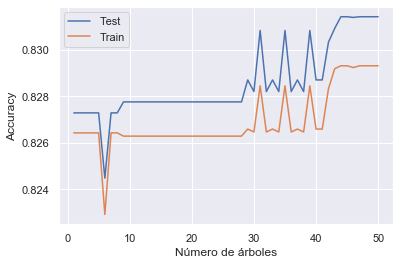

In [ ]:
accuracy_test = []
accuracy_train = []
# Calculamos el accuracy sobre el test set
for prediccion_test in ada_clf.staged_predict(X_test):
    accuracy_test.append(metrics.accuracy_score(prediccion_test,y_test))

for prediccion_train in ada_clf.staged_predict(X_train):
    accuracy_train.append(metrics.accuracy_score(prediccion_train,y_train))

plt.plot(range(1, len(accuracy_test) + 1), accuracy_test, label = 'Test')
plt.plot(range(1, len(accuracy_test) + 1), accuracy_train, label = 'Train')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Número de árboles')

7. Grafiquemos la frontera de decisión del clasificador

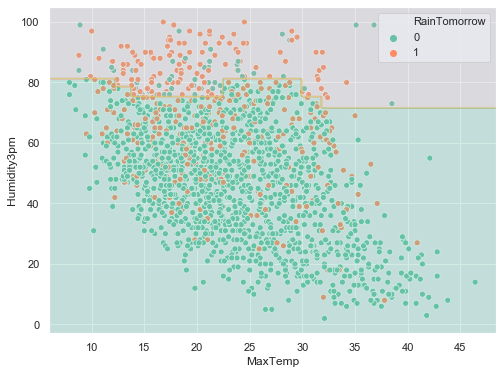

In [ ]:
N = 20 #para no graficar todos los puntos y saturar el grafico

plt.figure(figsize = (8,6))

ax = sns.scatterplot(X_test[::N].MaxTemp, X_test[::N].Humidity3pm, hue=y_test[::N], palette='Set2')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                      np.linspace(*ylim, num=200))
Z = ada_clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
contours = ax.contourf(xx, yy, Z, alpha=0.3, cmap = 'Set2')

plt.show()

8. Repita lo realizado hasta ahora pero utilice árboles de profundidad diez. Preste atención a las curvas de accuracy en train y test y al gráfico de la frontera. ¿Qué le parece que esta sucediendo en este caso?

In [17]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),algorithm='SAMME', n_estimators=50)
# Entrenamos el modelo
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3))

In [ ]:
X_train,X_test,y_train,Y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

In [20]:
"""Esto lo que hace es realizar predicciones en los datasets de entrenamiento y los de test para luego usando esas prediccinoes calcular el acurracy score mediante la libreria metrics de skitlearn"""

y_train_pred = ada_clf.predict(X_train)
y_test_pred = ada_clf.predict(X_test)
print(metrics.accuracy_score(y_train, y_train_pred))
print(metrics.accuracy_score(y_test, y_test_pred))


0.8290257694789176
0.8302733337269024


Text(0, 0.5, 'acurracy')

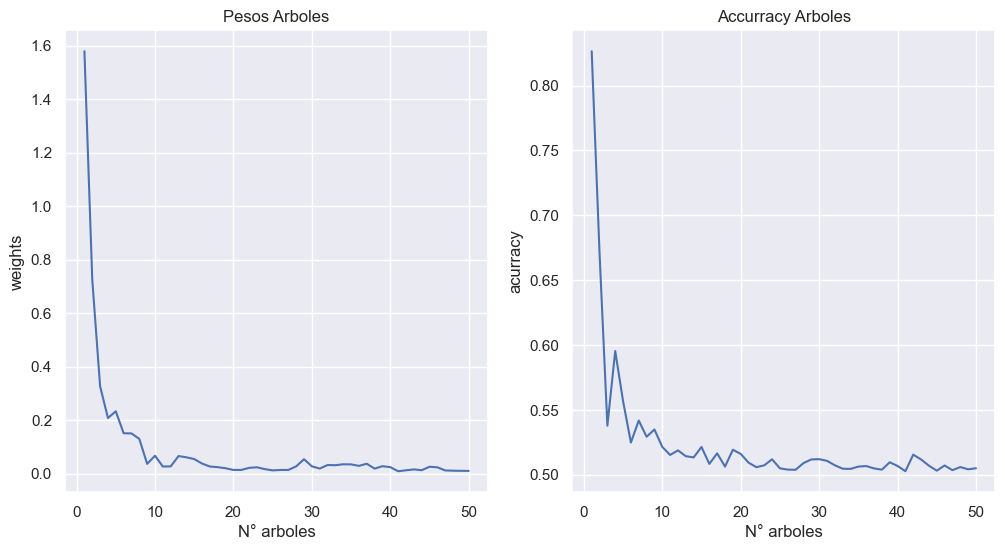

In [25]:
"""Lo que hace es calcular la cantidad total de arboles al calcular la longitud del estimadores que usa arboles y luego calcula el error y los pesos de cada arbol mediante el atributo correspondiente, luego calcula el complemento del error (accuracy) y grafica"""

n_arboles = len(ada_clf) # toma el numero de arboles

weights = ada_clf.estimator_weights_[:n_arboles]

error_arboles = ada_clf.estimator_errors_[:n_arboles]

acurracy_arboles = 1 - error_arboles

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(range(1,n_arboles+1),weights)
plt.title('Pesos Arboles')
plt.xlabel('N° arboles')
plt.ylabel('weights')
plt.subplot(122)
plt.plot(range(1,n_arboles+1),accuracy_arboles)
plt.title('Accurracy Arboles')
plt.xlabel('N° arboles')
plt.ylabel('acurracy')


In [26]:
ada_clf.estimator_weights_

array([1.579274  , 0.72600838, 0.32734721, 0.20893262, 0.23384049,
       0.15187968, 0.15122172, 0.13071639, 0.03742247, 0.06783843,
       0.02749137, 0.02807137, 0.06660929, 0.06195599, 0.05544943,
       0.03856421, 0.02746036, 0.02511253, 0.02109085, 0.01479276,
       0.01483713, 0.02265511, 0.02459481, 0.01782224, 0.01304454,
       0.01474863, 0.01478631, 0.0280346 , 0.05481908, 0.02830135,
       0.01993801, 0.03299022, 0.03249376, 0.03586732, 0.03557015,
       0.02991655, 0.03791133, 0.01968545, 0.02866294, 0.02521324,
       0.00986325, 0.01343482, 0.01674499, 0.01377628, 0.02665399,
       0.02457381, 0.01290078, 0.01188395, 0.01147492, 0.01116541])

In [27]:
ada_clf.estimator_errors_

array([0.17089833, 0.32607127, 0.41888623, 0.44795603, 0.44180482,
       0.4621029 , 0.46226645, 0.46736736, 0.49064547, 0.48304689,
       0.49312759, 0.49298262, 0.48335383, 0.48451595, 0.48614119,
       0.49036014, 0.49313534, 0.4937222 , 0.49472748, 0.49630188,
       0.49629078, 0.49433646, 0.49385161, 0.49554456, 0.49673891,
       0.49631291, 0.49630349, 0.49299181, 0.48629866, 0.49292514,
       0.49501566, 0.49175319, 0.49187727, 0.49103413, 0.4911084 ,
       0.49252142, 0.4905233 , 0.4950788 , 0.49283476, 0.49369702,
       0.49753421, 0.49664135, 0.49581385, 0.49655599, 0.4933369 ,
       0.49385686, 0.49677485, 0.49702905, 0.4971313 , 0.49720868])

c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Text(0, 0.5, 'Numero de arboles')

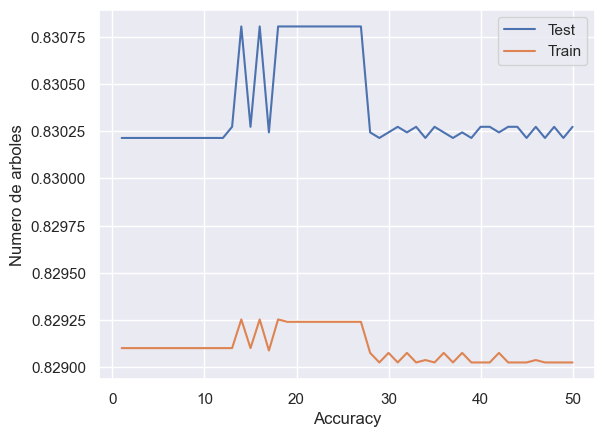

In [36]:
"""Variacion de error y el acurraccy en el traninig y en el test set a medida que agrego estimadores"""

accuracy_test = []
accuracy_train = []
for prediction_test in ada_clf.staged_predict(X_test):
    accuracy_test.append(metrics.accuracy_score(prediction_test,y_test))

for prediction_train in ada_clf.staged_predict(X_train):
    accuracy_train.append(metrics.accuracy_score(prediction_train,y_train))

plt.plot(range(1,len(accuracy_test)+1),accuracy_test,label= 'Test')
plt.plot(range(1,len(accuracy_train)+1),accuracy_train,label='Train')
plt.legend()
plt.xlabel('Accuracy')
plt.ylabel('Numero de arboles')

c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Text(0, 0.5, 'Numero de arboles')

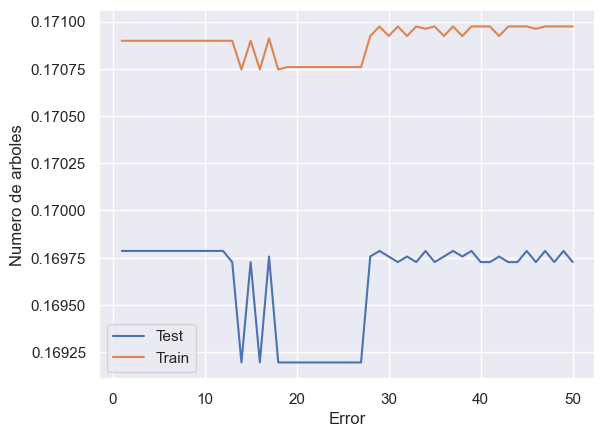

In [37]:
"""Variacion de error y el acurraccy en el traninig y en el test set a medida que agrego estimadores"""

error_test = []
error_train = []
for prediction_test in ada_clf.staged_predict(X_test):
    error_test.append(1-metrics.accuracy_score(prediction_test,y_test))

for prediction_train in ada_clf.staged_predict(X_train):
    error_train.append(1-metrics.accuracy_score(prediction_train,y_train))

plt.plot(range(1,len(error_test)+1),error_test,label= 'Test')
plt.plot(range(1,len(error_train)+1),error_train,label='Train')
plt.legend()
plt.xlabel('Error')
plt.ylabel('Numero de arboles')